In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import lsst.afw.display.rgb as rgb

In [2]:
import os
import sys

import pandas as pd
import sqlite3
import functools
import itertools
import importlib
import operator

import astropy
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize
import astropy.units as u
import astropy.coordinates as coord

import lsst.geom
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')
from lsst.ap.association import UnpackApdbFlags, MapDiaSourceConfig
from lsst.utils import getPackageDir

In [3]:
from lsst.obs.lsstSim import LsstSimMapper

In [4]:
from python.notebook_utils import load_diffim, load_coaddSources, plot_diffim_quiver
from python.simulation_utils import simulation_wrapper

Run the *catalog*-only simulation, matching the values used in DM-20958

In [5]:
n_star = 1000000
n_quasar = 10000
seed = 73
attenuation = 20.
wavelength_step = 10
dimension = 1024
pixel_scale = 0.25
simulation_size = 1.
hottest_star='F'
coolest_star = 'M'
sim = simulation_wrapper(seed=seed, n_star=n_star, n_quasar=n_quasar,
                         output_directory=None,
                         attenuation=attenuation, wavelength_step=wavelength_step,
                         dimension=dimension, pixel_scale=pixel_scale,
                         simulation_size=simulation_size,
                         write_catalog=False, write_fits=False, do_simulate=False,
                         hottest_star=hottest_star, coolest_star=coolest_star)

Number and flux contribution of stars of each type:
 [M 771472| 13.49%] [K 121791| 15.93%] [G 76464| 32.06%] [F 30273| 38.52%] [A 0| 0.00%] [B 0| 0.00%] [O 0| 0.00%]


In [6]:
area = (dimension*pixel_scale/3600)**2
print(f"{area} square degrees")

0.00505679012345679 square degrees


In [31]:
seeing_range = {}
seeing = 1.0
for seeing_id in range(1,5):
    seeing_range[seeing_id] = (seeing - 1)*100
    seeing *= 1.2

In [7]:
sim.star_flux?

In [8]:
sim_repo = "/Users/sullivan/LSST/simulations/OpSim/pontus_2568/mosaic_73_varPSF_rand/input_data/rerun/processed_data/rerun/"

In [11]:
butler_1_0_seeing_cw = dafPersist.Butler(sim_repo + "seeing_cw_1")
butler_1_2_seeing_cw = dafPersist.Butler(sim_repo + "seeing_cw_2")
butler_1_4_seeing_cw = dafPersist.Butler(sim_repo + "seeing_cw_3")
butler_1_7_seeing_cw = dafPersist.Butler(sim_repo + "seeing_cw_4")

In [12]:
dataId = {'filter': 'g', 'tract': 0, 'patch': '0,0'}

In [13]:
butler_1_0_seeing_cw.datasetExists("deepCoadd", dataId=dataId)

True

In [14]:
dataId = {'filter': 'g', 'tract': 0, 'patch': '0,0'}
meas_cat = butler_1_0_seeing_cw.get("deepCoadd_meas", dataId=dataId)

In [17]:
butler_1_0_seeing_dcr = dafPersist.Butler(sim_repo + "seeing_dcr_1", mapper=LsstSimMapper)
butler_1_2_seeing_dcr = dafPersist.Butler(sim_repo + "seeing_dcr_2", mapper=LsstSimMapper)
butler_1_4_seeing_dcr = dafPersist.Butler(sim_repo + "seeing_dcr_3", mapper=LsstSimMapper)
butler_1_7_seeing_dcr = dafPersist.Butler(sim_repo + "seeing_dcr_4", mapper=LsstSimMapper)

In [18]:
visits_template_1_0 = np.arange(1010000, 1010008)
visits_template_1_2 = np.arange(1010100, 1010108)
visits_template_1_4 = np.arange(1010200, 1010208)
visits_template_1_7 = np.arange(1010300, 1010308)
visits_alerts = np.arange(2000000, 2000024)

In [19]:
butler0 = dafPersist.Butler(sim_repo + "seeing_cw_1/")
ref_dataId = {'visit': visits_alerts[0], 'filter': 'g', 'raft':'2,2', 'sensor':'1,1'}
significance_image = butler0.get("deepDiff_matchedExp", dataId=ref_dataId)
mask = significance_image.mask
significance_image = significance_image.image.array
significance_image[~np.isfinite(significance_image)] = 0.
significance_image = np.abs(significance_image)
significance_image[significance_image > 100] = 100.

In [24]:
template_dcr = {}
alerts_dcr = {}
deep_rerun_base = "seeing_cw_"
dcr_rerun_base = "seeing_dcr_"
visits_alerts = [[2000000, 2000024]]

for seeing_id in range(1, 5):
    seeing_name = "%i/" % seeing_id
    visits_template = [[1010000 + (seeing_id - 1)*100, 1010007 + (seeing_id - 1)*100]]
    template_dcr0, alerts_dcr0 = load_diffim(sim_repo,
                                             deep_rerun_base + seeing_name, dcr_rerun_base + seeing_name,
                                             visits_template, visits_alerts,
                                             filter_name='g', coaddName='dcr',
                                             mask=mask, significance_image=significance_image)
    template_dcr[seeing_id] = template_dcr0
    alerts_dcr[seeing_id] = alerts_dcr0

Skipping 2000005, no data.
Skipping 2000024, no data.
Skipping 2000005, no data.
Skipping 2000024, no data.
Skipping 2000005, no data.
Skipping 2000024, no data.
Skipping 2000005, no data.
Skipping 2000024, no data.


In [28]:
template_cw = {}
alerts_cw = {}

for seeing_id in range(1, 5):
    seeing_name = "%i/" % seeing_id
    visits_template = [[1010000 + (seeing_id - 1)*100, 1010007 + (seeing_id - 1)*100]]
    template_cw0, alerts_cw0 = load_diffim(sim_repo,
                                           deep_rerun_base + seeing_name, dcr_rerun_base + seeing_name,
                                           visits_template, visits_alerts,
                                           filter_name='g', coaddName='deep',
                                           mask=mask, significance_image=significance_image)
    template_cw[seeing_id] = template_cw0
    alerts_cw[seeing_id] = alerts_cw0

Skipping 2000005, no data.
Skipping 2000024, no data.
Skipping 2000005, no data.
Skipping 2000024, no data.
Skipping 2000005, no data.
Skipping 2000024, no data.
Skipping 2000005, no data.
Skipping 2000024, no data.


## Look at the table of observing conditions and difference imaging results
For simplicity, only display the results for the constant seeing templates, since that is the best case scenario for DCR.

In [141]:
alerts_dcr0.show_in_notebook()

idx,fieldId,year,visit,airmass,parAng,dcr [2],nDipole,nSrc,avgResidual,avgSrcResidual,psfSigma,nFalseNoise
0,0000,2,2000000,1.01780438455895,0.0,0.24001787018097903 .. 0.0,179,881,27.962557,7.9786773,1.36341756455976,0.3335504118696119
1,0000,2,2000001,1.02119564737363,0.0,0.262102724861294 .. 0.0,175,886,27.802456,7.967159,1.3667733987051842,0.3319144922552468
2,0000,2,2000002,1.08055119571983,0.0,0.5184793798977004 .. 0.0,65,531,27.570858,6.9935317,1.7350351009053133,0.20596940760333854
3,0000,2,2000003,1.06354999523534,0.0,0.4586203833709746 .. 0.0,89,679,25.860546,7.5957184,1.487684704851111,0.2801544043798416
4,0000,2,2000004,1.03679477574562,0.0,0.34667838005903495 .. 0.0,89,583,27.255983,7.0057697,1.6644263889193078,0.22381545119303858
5,0000,2,2000006,1.11884035770152,179.99999999999994,-0.6355934545946409 .. 6.42358139046445e-16,221,563,34.735764,8.260684,1.8591212548446634,0.17939230838463202
6,0000,2,2000007,1.2381174801844,0.0,0.924965836357798 .. 0.0,58,598,26.720516,7.8785553,1.614799664279471,0.2377836282863815
7,0000,2,2000008,1.0445315957944,0.0,0.3821194316775272 .. 0.0,84,559,27.404224,7.072081,1.6844699749362173,0.21852075984034913
8,0000,2,2000009,1.04465156176929,0.0,0.38264512704778825 .. 0.0,127,913,27.561556,8.1728735,1.3309916058958426,0.35000046181419003
9,0000,2,2000010,1.01359516390177,179.99999999999994,-0.20951474797191053 .. 2.1174463430535797e-16,233,680,30.13375,7.642938,1.651195371706604,0.2274166853060388


In [142]:
alerts_cw0.show_in_notebook()

idx,fieldId,year,visit,airmass,parAng,dcr [2],nDipole,nSrc,avgResidual,avgSrcResidual,psfSigma,nFalseNoise
0,0000,2,2000000,1.01780438455895,0.0,0.24001787018097903 .. 0.0,166,297,21.969444,3.8803806,1.36341756455976,0.3335504118696119
1,0000,2,2000001,1.02119564737363,0.0,0.262102724861294 .. 0.0,148,280,21.644228,3.8237028,1.3667733987051842,0.3319144922552468
2,0000,2,2000002,1.08055119571983,0.0,0.5184793798977004 .. 0.0,5,53,23.200191,3.9409924,1.7350351009053133,0.20596940760333854
3,0000,2,2000003,1.06354999523534,0.0,0.4586203833709746 .. 0.0,21,97,20.705833,3.8496866,1.487684704851111,0.2801544043798416
4,0000,2,2000004,1.03679477574562,0.0,0.34667838005903495 .. 0.0,41,131,23.187067,4.064477,1.6644263889193078,0.22381545119303858
5,0000,2,2000006,1.11884035770152,179.99999999999994,-0.6355934545946409 .. 6.42358139046445e-16,304,616,33.399364,6.3183722,1.8591212548446634,0.17939230838463202
6,0000,2,2000007,1.2381174801844,0.0,0.924965836357798 .. 0.0,11,73,20.920023,3.7553189,1.614799664279471,0.2377836282863815
7,0000,2,2000008,1.0445315957944,0.0,0.3821194316775272 .. 0.0,32,112,23.232147,4.0612226,1.6844699749362173,0.21852075984034913
8,0000,2,2000009,1.04465156176929,0.0,0.38264512704778825 .. 0.0,80,178,19.87301,3.5519025,1.3309916058958426,0.35000046181419003
9,0000,2,2000010,1.01359516390177,179.99999999999994,-0.20951474797191053 .. 2.1174463430535797e-16,288,529,28.630714,5.341851,1.651195371706604,0.2274166853060388


## It is apparent that the DCR templates are generating far more false detections than the CompareWarp templates
There are cases where CompareWarp performs much worse than usual, though, so it is worth digging deeper.

Let's directly compare the two styles of templates to look for correlations.

In [55]:
def plot_diffim_combined(deep_tables, dcr_tables, seeing_range,
                         quantity="nDipole", window=1, seeing_list=None, relative=True,
                         **kwargs):
    afwDisplay.Display(window)
    plt.figure(window)
    colors = 'bgrcmyk'
    names = []
    if seeing_list is None:
        seeing_list = [seeing_id for seeing_id in seeing_range.keys()]
    for ind, seeing_id in enumerate(seeing_list):
        names.append("%2.0f%% (rising)" % seeing_range[seeing_id])
        names.append("%2.0f%% (falling)" % seeing_range[seeing_id])
        deep_table = deep_tables[seeing_id]
        dcr_table = dcr_tables[seeing_id]

        q1 = deep_table[quantity].quantity
        q2 = dcr_table[quantity].quantity
        airmass = deep_table["airmass"].quantity
        par_ang = deep_table["parAng"].quantity
        par_ang_flag = np.abs(par_ang) > 100
        x = airmass
        if relative:
            y = (q1 - q2)/q1
            plt.plot(x[~par_ang_flag], y[~par_ang_flag], colors[ind] + '+')
            plt.plot(x[par_ang_flag], y[par_ang_flag], colors[ind] + 'x')
        else:
        plt.grid(True)
    plt.ylabel('Fractional reduction in false detections')
    plt.ylim(bottom=-9, top=1.0)
    plt.xlabel('Airmass')
    plt.legend(names)

<IPython.core.display.Javascript object>


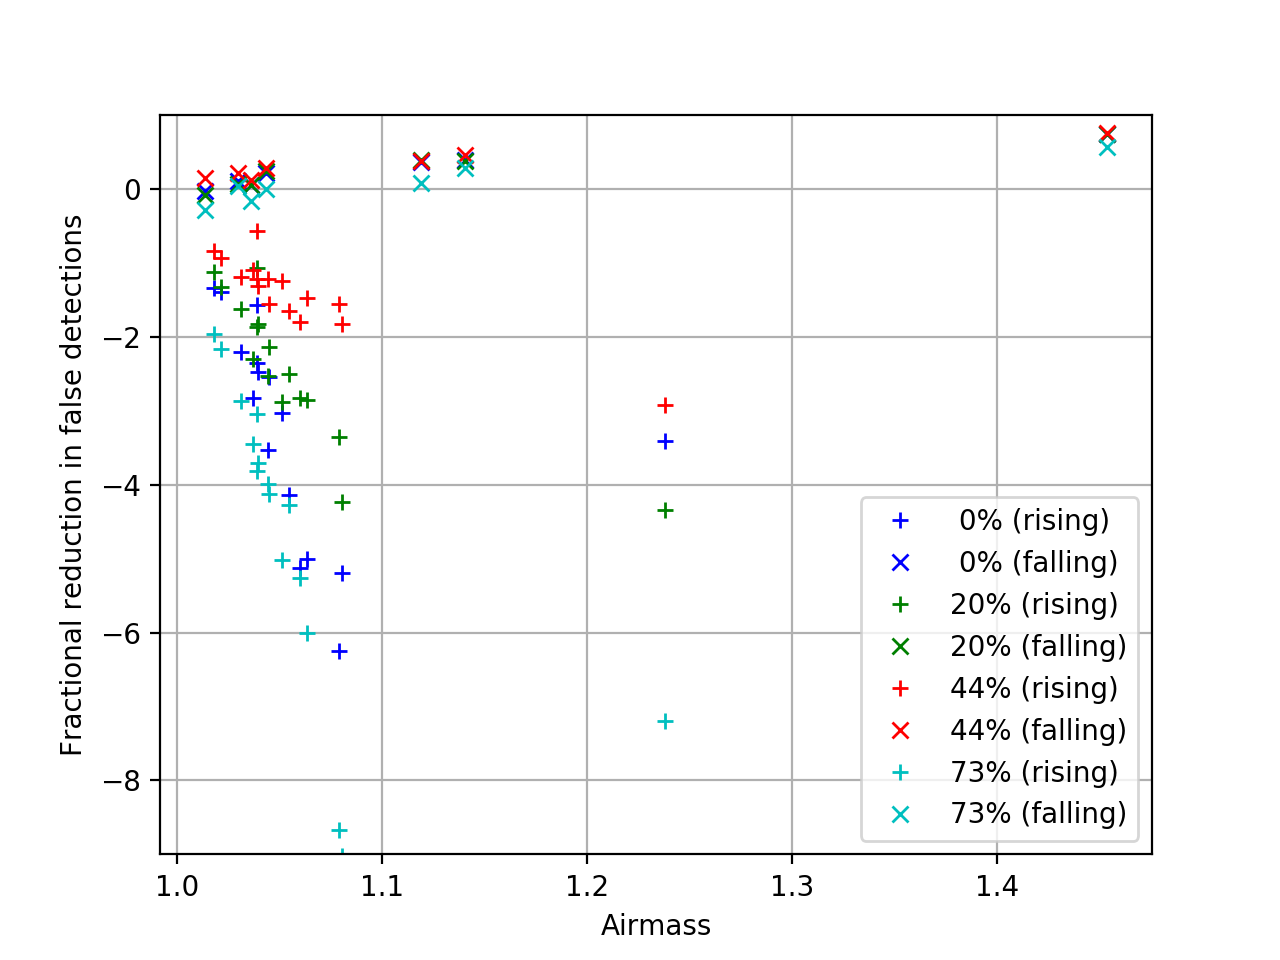

In [90]:
plot_diffim_combined(alerts_cw, alerts_dcr, seeing_range, window=1, quantity='nSrc')

### Note: in the above plot, negative values mean the number of detected difference image sources *increased*
A "fractional reduction in false detections" of -1 means there were 100% *more* false detections using the DCR coadd, so for most of the observations the DCR template is performing much worse than the CompareWarp template.
However, the observations taken while the field was setting show a consistent reduction in the number of false detections.
Looking at the raw tables above, it is clear that this is because the CompareWarp template is performing much worse for these observations, rather than the DCR template performing better.
This difference strongly suggests that the problem with the DCR templates is that there are artifacts in the model that result in a similar number of false detections regardless of the observing conditions.

The consistent performance of the DCR template suggests that the model is working correctly, aside from the artifacts.

## Look at example images of the matched templates used for image differencing.
The images below are using the matched exposures generated during image differencing, so the DCR template includes the forward-modeled DCR for the chosen science exposure.

In [61]:
dataId = {'visit': 2000006, 'filter': 'g', 'raft':'2,2', 'sensor':'1,1'}
template_image_dcr = butler_1_0_seeing_dcr.get("dcrDiff_matchedExp", dataId=dataId)
template_image_cw = butler_1_0_seeing_cw.get("deepDiff_matchedExp", dataId=dataId)

In [124]:
def look(coadd, diff=None, window=None, title="Coadd", min=None, max=None, zoom=None):
    disp = afwDisplay.Display(window)
    if (min is None) | (max is None):
        disp.scale('asinh', 'zscale')
    else:
        disp.scale('linear', min, max=max)
    if diff is None:
        image = coadd.image
    else:
        image = coadd.image.clone()
        image -= diff.image
    disp.mtv(image, title=title)
    if zoom is not None:
        disp.zoom(zoom)

<IPython.core.display.Javascript object>


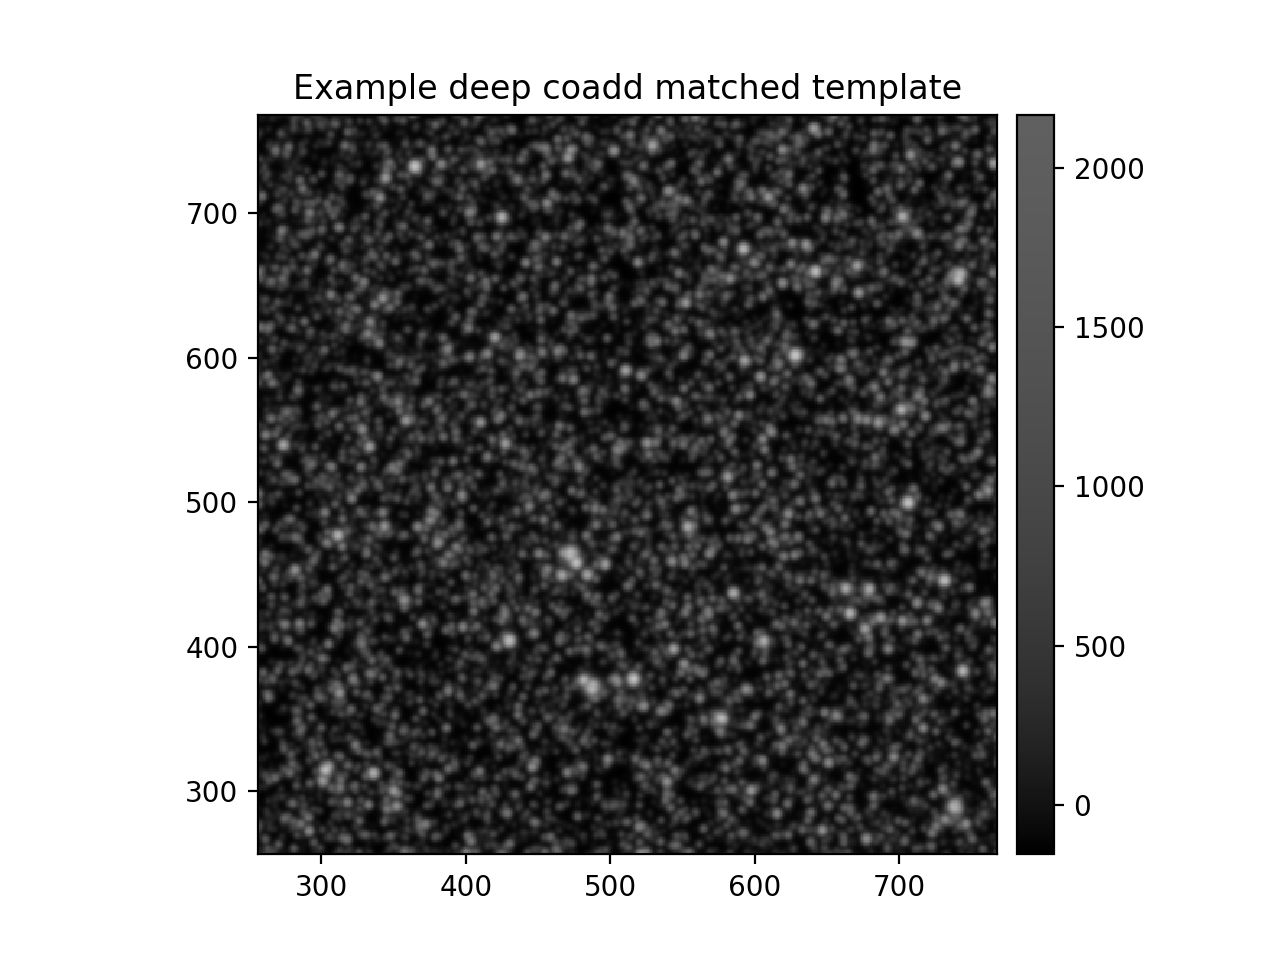

In [130]:
look(template_image_cw, title="Example deep coadd matched template", window=2, zoom=4)

<IPython.core.display.Javascript object>


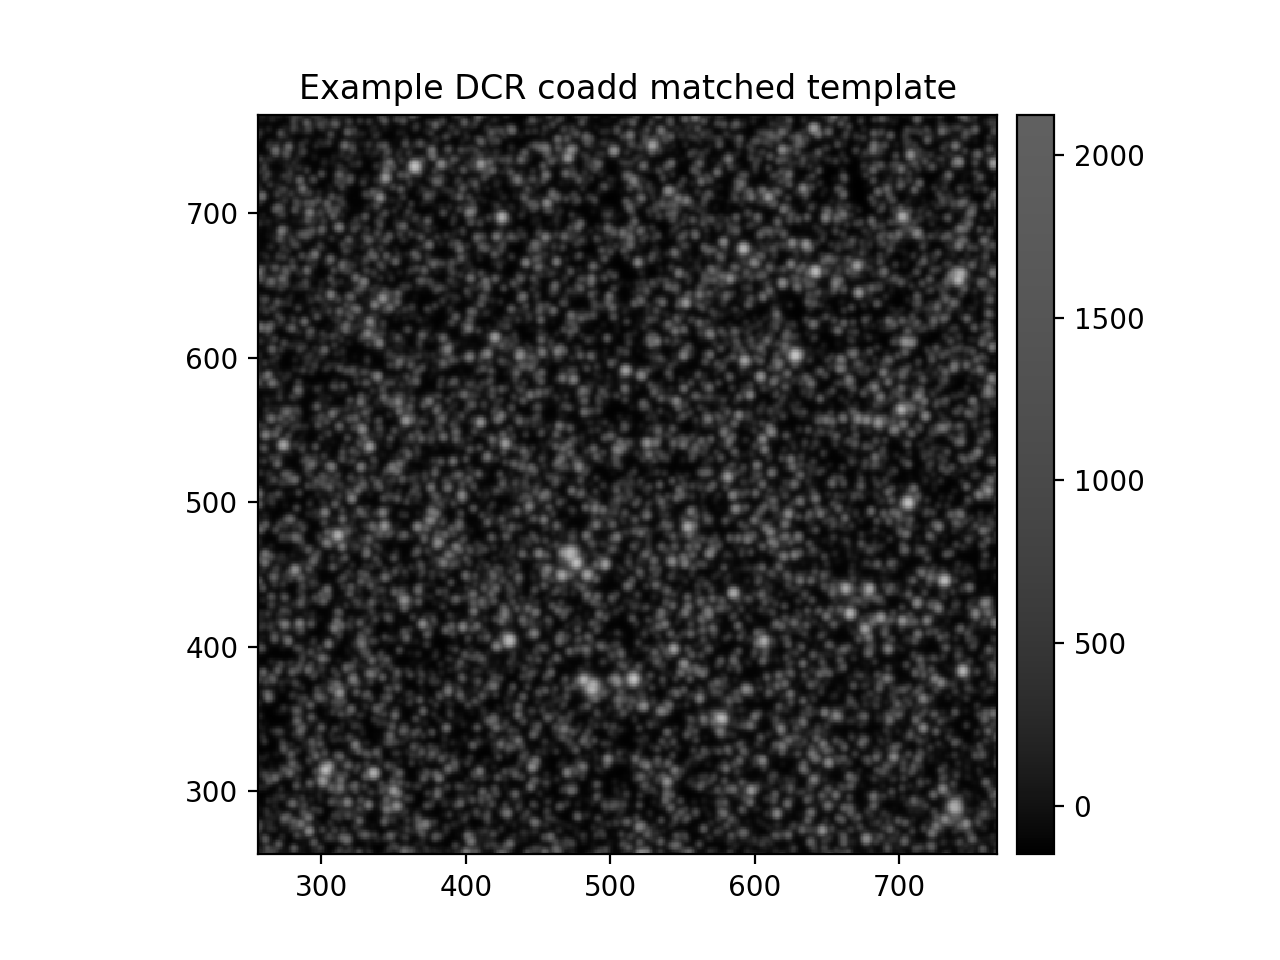

In [131]:
look(template_image_dcr, title="Example DCR coadd matched template", window=3, zoom=4)

<IPython.core.display.Javascript object>


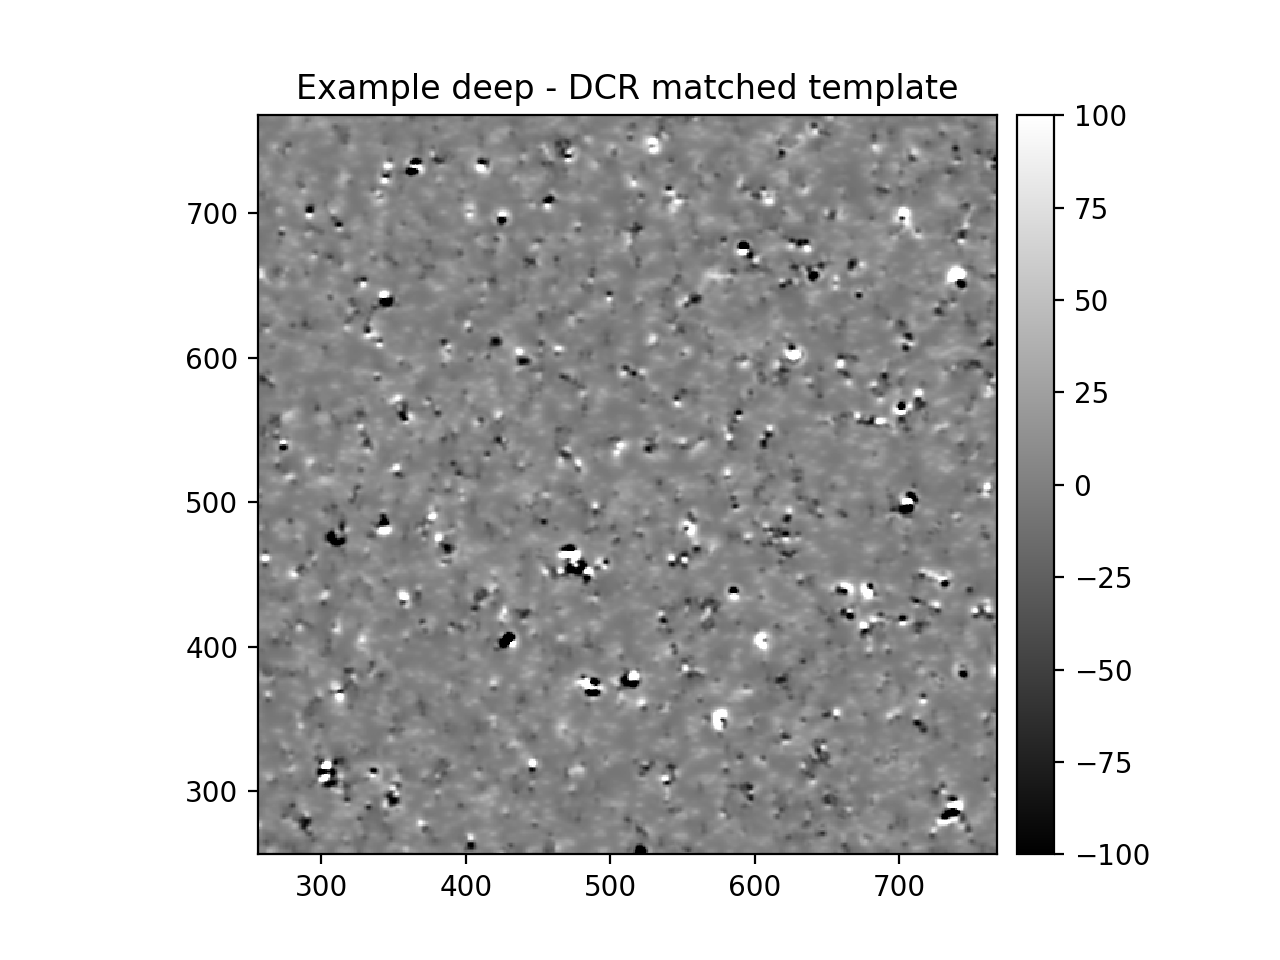

In [129]:
look(template_image_cw, diff=template_image_dcr, window=5, title="Example deep - DCR matched template",
     min=-100, max=100, zoom=4)

### The DCR and CompareWarp matched images look very similar, but the difference of the two shows the problems.
It looks as though the strong positive and negative peaks tend to be clustered together.
This suggests that the artifacts in the DCR model arise where there are bright overlapping sources -- which is not much of a suprise.

# Conclusions

Unfortunately, the DCR templates result in many more false detections in the majority of images.
These false detections appear to be caused by artifacts related to overlapping bright sources, and are relatively consistent compared to the false detections using CompareWarp templates.
It is interesting to note that there is a dramatic difference in the number of false detections depending on whether the observed field is rising or setting at the time.
Most of the observations that went into building the templates were made while the field was rising, so the CompareWarp template performs badly when the science observation is taken while the field is setting.

Based on these differences, I believe the problem with the DCR model was that the shifts of the sub-bands used to build it were too large, and flux from overlapping sources is getting mixed.
The fix would have to be to use more observations to build the model, and to use more sub-bands with finer frequency resolution.